In [1]:
# Packages, plotting parameters, and folder to save/read data
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv 
import seaborn as sns
from scipy.signal import savgol_filter

# Update plotting parameters
params = {'legend.fontsize': 'xx-large',         
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'font.sans-serif': "Arial",
          'font.family': "sans-serif",
          'figure.figsize': (6, 6),
         }
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update(params)
font = {'family' : 'sans-serif',
        'size'   : 14}
mpl.rc('font', **font)

# Folder data 
data_folder = "./2021_October4_Crytur20-50-100um_FIB/"
fig_folder = "figs/October4_figs/"

In [2]:
# Reads image data and associated line cuts, calculating scintillation enhancement on/off sample
def read_data(file, plot_flag = True, plot_window = ([0,1014],[0,1014])):
    # Reads correlated .csv and image data 
    file0 = data_folder + file
    try:
        img = mpimg.imread(file0 + ".jpg")
        img = np.squeeze(img)
    except FileNotFoundError: 
        try:
            img = mpimg.imread(file0 + ".png")
            img = np.squeeze(img[:,:,0])
        except FileNotFoundError:
            img = []
    pixels, cut, pixels_bg, cut_bg = [], [], [], []
    with open(file0 + '.csv','r') as csvfile: 
        reader = csv.reader(csvfile, delimiter=',', quotechar='|') 
        for row in reader:
            pixels.append(float(row[0]))
            cut.append(float(row[1]))
        pixels = np.array(pixels)
        cut = np.array(cut)
    try:
        with open(file0 + '_Off.csv','r') as csvfile: 
            reader = csv.reader(csvfile, delimiter=',', quotechar='|') 
            for row in reader:
                pixels_bg.append(float(row[0]))
                cut_bg.append(float(row[1]))
            pixels_bg = np.array(pixels_bg)
            cut_bg = np.array(cut_bg)   
    except FileNotFoundError:
        pixels_bg = pixels
        cut_bg = np.ones_like(cut)
    diffcut_smooth = np.diff(savgol_filter(cut,7,1))
    (lp, rp) = (np.where(diffcut_smooth == np.max(diffcut_smooth))[0][0]+2, np.where(diffcut_smooth == np.min(diffcut_smooth))[0][0]-2)
    on_square = np.mean(cut[lp:rp])
    off_square = (np.mean(cut[:lp])+np.mean(cut[rp:]))/2.0
    background = np.mean(cut_bg) 
    print(file)
    print("Enhancement (no bg sub.) : {0} vs. {1} = {2} ({3} %)".format(on_square, off_square, on_square/off_square, (on_square-off_square)/off_square*100.))
    if background > off_square:
        print("Careful! Background is larger than signal.")
    else:
        print("Enhancement : {0} vs. {1} = {2} ({3} %)".format(on_square-background, off_square-background, (on_square-background)/(off_square-background), (on_square-off_square)/(off_square-background)*100.))
    if plot_flag:
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        implot = axs[1].imshow(img[plot_window[1][0]:plot_window[1][1],plot_window[0][0]:plot_window[0][1]], cmap = "inferno")
        axs[1].axis('off')
        axs[1].set_title(file)        
        fig.colorbar(implot)
        axs[0].plot(pixels, cut, label = "signal")
        axs[0].plot(pixels[lp:rp], cut[lp:rp], 'x', label = "on square")
        axs[0].set_xlabel("Pixel index")
        axs[0].set_xticks([0,np.max(pixels)])        
        axs[0].plot(pixels_bg, cut_bg, label = "bg")
        axs[0].legend()        
        # plt.savefig("figs/"+file+".svg")
    return img, pixels, cut, pixels_bg, cut_bg, on_square, off_square, background

# Experimental data analysis 20 microns sample (Figure 4, October 4th, 2021)

FF01-549-15-25_20microns_A1_DustOffCenter_Air
Enhancement (no bg sub.) : 7229.081736842105 vs. 977.4274823313782 = 7.396028725935928 (639.6028725935929 %)
Enhancement : 7027.193559064327 vs. 775.5393045536005 = 9.061041159105626 (806.1041159105625 %)


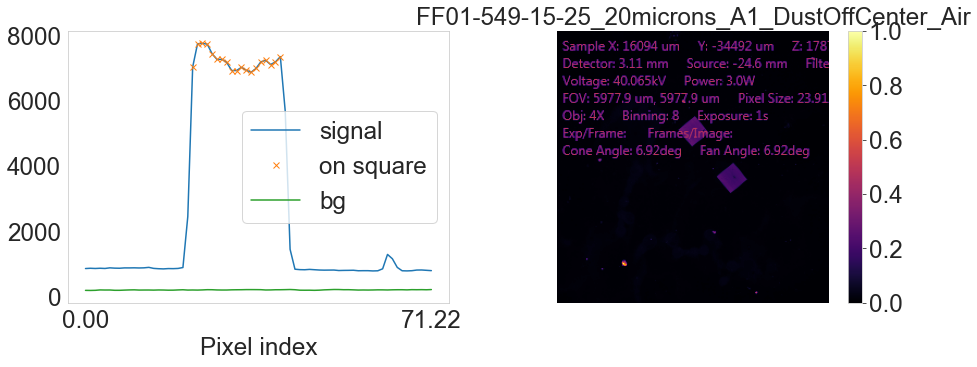

In [3]:
# Enhancement from cut 
img, pixels, cut, pixels_bg, cut_bg, on_square, off_square, background = read_data("FF01-549-15-25_20microns_A1_DustOffCenter_Air");

# Checking the influence of reflector

FF01-549-15-25_20micronsRef_ThroughSilver_Air
Enhancement (no bg sub.) : 2664.375 vs. 929.8237596153848 = 2.8654623765498317 (186.54623765498317 %)
Enhancement : 2542.0435097345135 vs. 807.492269349898 = 3.1480716363774985 (214.8071636377498 %)
Reflector enhancement = 968.813812764816/507.2449281555659 = 1.9099526855548814


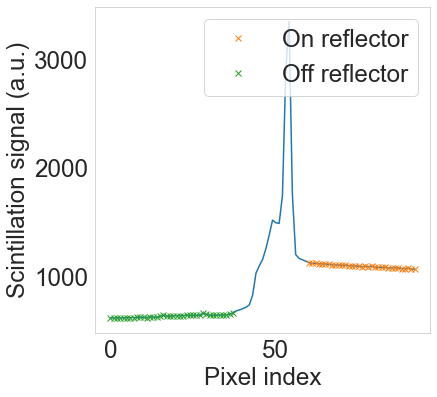

In [4]:
img, pixels, cut, pixels_bg, cut_bg, on_square, off_square, background = read_data("FF01-549-15-25_20micronsRef_ThroughSilver_Air", plot_flag=False);
onref_indices = np.arange(60, len(pixels))
offref_indices = np.arange(0, 38)

plt.figure()
plt.xlabel("Pixel index")
plt.ylabel("Scintillation signal (a.u.)")
plt.plot(pixels, cut)
plt.plot(pixels[onref_indices], cut[onref_indices], 'x', label = "On reflector")
plt.plot(pixels[offref_indices], cut[offref_indices], 'x', label = "Off reflector")
print("Reflector enhancement = {0}/{1} = {2}".format(np.mean(cut[onref_indices])-np.mean(background),
                                                     np.mean(cut[offref_indices])-np.mean(background),
                                                    (np.mean(cut[onref_indices])-np.mean(background))/(np.mean(cut[offref_indices])-np.mean(background))))
plt.legend()                                                    